In [2]:
import pandas as pd

# Load the dataset into a pandas DataFrame
file_path = '/content/Hwy26Crashes2019_S23_DataSet.csv'
crash_data = pd.read_csv(file_path)




In [103]:
# Define validation functions
def validate_existence_for_record_type(data, columns, record_type):
    """Check if specified columns are not null in the dataframe for a specific record type."""
    filtered_data = data[data['Record Type'] == record_type]
    return filtered_data[columns].notna().all()

def validate_year_for_record_type(data, year, record_type):
    """Check if all entries in the 'Crash Year' column equal to the specified year for a specific record type."""
    filtered_data = data[data['Record Type'] == record_type]
    return (filtered_data['Crash Year'] == year).all()

def validate_coordinates_for_record_type(data, record_type):
    """Check if latitude and longitude degrees are within Oregon's typical boundaries for a specific record type."""
    filtered_data = data[data['Record Type'] == record_type]
    valid_lat = filtered_data['Latitude Degrees'].between(42, 46.5)
    valid_long = filtered_data['Longitude Degrees'].between(-124.5, -116.5)
    return valid_lat.all() and valid_long.all()

def validate_related_fields(data, field1, field2):
    """Check if both fields are filled whenever one is filled."""
    both_filled = data[[field1, field2]].dropna(how='any').notna()
    return both_filled[field1].equals(both_filled[field2])


def check_alcohol_and_drug_report(crash_data):
    return (~crash_data['Alcohol Use Reported'].astype(bool) | crash_data['Drug Use Reported'].astype(bool)).all()


def check_pedestrian_location(crash_data):
    pedestrians = crash_data['Participant Type Code'].isin(['3', '4', '5'])
    return crash_data.loc[pedestrians, 'Non-Motorist Location'].notna().all()

def check_unique_crash_identifiers(data,record_type):
    filtered_data = data[data['Record Type'] == record_type]
    return not filtered_data.duplicated(subset=['Serial #', 'County Code', 'Crash Year'], keep=False).any()

def summary_fatal_injuries(data,record_type):
    filtered_data = data[data['Record Type'] == record_type]
    total_fatalities = filtered_data[filtered_data['Injury Severity'] == 1]
    return len(total_fatalities)




# Perform validations
existence_checks = validate_existence_for_record_type(crash_data, ['Serial #', 'Crash Month', 'Crash Day', 'Crash Year'],1)
year_check = validate_year_for_record_type(crash_data,2019,1)
coordinate_check = validate_coordinates_for_record_type(crash_data,1)
city_county_check = validate_related_fields(crash_data, 'City Section ID', 'County Code')
roundabout_intersection_check=check_roundabout_in_intersection_type(crash_data,1)
alcoholdrugcheck=check_alcohol_and_drug_report(crash_data)
checkpedestrianlocation=check_pedestrian_location(crash_data)
checkuniquecrashidentifiers=check_unique_crash_identifiers(crash_data,1)

# Output results
results = {
    "Existence Checks (Serial #, Date components)": existence_checks,
    "Year Check (2019)": year_check,
    "Coordinate Check (Within Oregon)": coordinate_check,
    "City and County Check": city_county_check,
    "Latitude and Longitude Check": lat_long_check,
    "alcohol Drug Check": alcoholdrugcheck,
    "check pedestrian location":checkpedestrianlocation,
    "checkuniquecrashidentifiers": checkuniquecrashidentifiers,
    "summary fatal injuries" : summaryfatalinjuries
}

# Display results
print(results)

{'Existence Checks (Serial #, Date components)': Serial #       True
Crash Month    True
Crash Day      True
Crash Year     True
dtype: bool, 'Year Check (2019)': True, 'Coordinate Check (Within Oregon)': True, 'City and County Check': True, 'Latitude and Longitude Check': True, 'alcohol Drug Check': True, 'check pedestrian location': True, 'checkuniquecrashidentifiers': True, 'summary fatal injuries': 3}


In [101]:
# Inter-Record assertion
def check_unique_participant_ids(participant_data):
    # Check for unique Participant IDs in the participant_data
    participant_ids_unique = participant_data['Participant ID'].is_unique
    return participant_ids_unique

def check_crash_id_correspondence(participant_data, crash_data):
    # Check that each Crash ID in participant_data matches a Crash ID in crash_data
    participant_crash_ids = participant_data['Crash ID'].unique()
    crash_ids = crash_data['Crash ID'].unique()
    # Each element of participant_crash_ids should be in crash_ids
    all_match = all(pid in crash_ids for pid in participant_crash_ids)
    return all_match

crash_data1 = crash_data[crash_data['Record Type'] == 1]
participant_data = crash_data[crash_data['Record Type'] == 3]

# Now you can call these functions and print the results:
unique_participant_ids_check = check_unique_participant_ids(participant_data)
crash_id_correspondence_check = check_crash_id_correspondence(participant_data, crash_data1)

print("Unique Participant IDs Check:", unique_participant_ids_check)
print("Crash ID Correspondence Check:", crash_id_correspondence_check)


Unique Participant IDs Check: True
Crash ID Correspondence Check: True


In [102]:
# Inter-Record assertion

# Every vehicle listed in the crash data was part of a known crash
vehicle_data=crash_data[crash_data['Record Type'] == 2]
crash_data1=crash_data[crash_data['Record Type'] == 1]
unknown_crashes = set(vehicle_data['Crash ID']) - set(crash_data1['Crash ID'])
if unknown_crashes:
    print(f"There are vehicles listed with crash IDs that do not match any known crash: {unknown_crashes}")
else:
    print("All vehicles are part of a known crash.")
# Vehicles which are involved in a crash but not with an object at the time of the crash
crash_data1_list = []
vehicle_data_list = []
# Read data into lists using filtered DataFrames
for row in crash_data1.to_dict(orient='records'):
    crash_data1_list.append(row)

for row in vehicle_data.to_dict(orient='records'):
    vehicle_data_list.append(row)
crash_vehicle_ids = set([row['Vehicle ID'] for row in vehicle_data_list])

for vehicle_id in crash_vehicle_ids:
    has_collision = any([row["Crash Type"] == "8" for row in crash_data1_list if row["Crash ID"] == vehicle_id])

    if vehicle_id in crash_vehicle_ids and not has_collision:
        print(f"Vehicle {vehicle_id} became involved in a crash but did not hit anything.")

All vehicles are part of a known crash.
Vehicle 3483652.0 became involved in a crash but did not hit anything.
Vehicle 3483653.0 became involved in a crash but did not hit anything.
Vehicle 3479559.0 became involved in a crash but did not hit anything.
Vehicle 3479560.0 became involved in a crash but did not hit anything.
Vehicle 3461130.0 became involved in a crash but did not hit anything.
Vehicle 3461131.0 became involved in a crash but did not hit anything.
Vehicle 3465226.0 became involved in a crash but did not hit anything.
Vehicle 3465227.0 became involved in a crash but did not hit anything.
Vehicle 3489808.0 became involved in a crash but did not hit anything.
Vehicle 3489809.0 became involved in a crash but did not hit anything.
Vehicle 3479570.0 became involved in a crash but did not hit anything.
Vehicle 3479571.0 became involved in a crash but did not hit anything.
Vehicle 3479572.0 became involved in a crash but did not hit anything.
Vehicle 3483668.0 became involved in 

In [95]:
# Summary assertion
data=crash_data
def summary_fatal_injuries(data,record_type):
    filtered_data = data[data['Record Type'] == record_type]
    total_fatalities = filtered_data[filtered_data['Injury Severity'] == 1]
    return len(total_fatalities)

summaryfatalinjuries=summary_fatal_injuries(crash_data,3)
print(summaryfatalinjuries)



3


In [49]:
# Summary assertion
crash_id = set()
filtered_data = crash_data[crash_data['Record Type'] == 1]
print(len(filtered_data))
for index, row in filtered_data.iterrows():
    if row['Record Type'] == 1:
        if row['Crash ID'] in crash_id:
            print("Crash ID is repeated ", index, row['Crash ID'])
            filtered_data.drop(index, inplace=True)
        else:
            crash_id.add(row['Crash ID'])
print(len(crash_id))

508
508


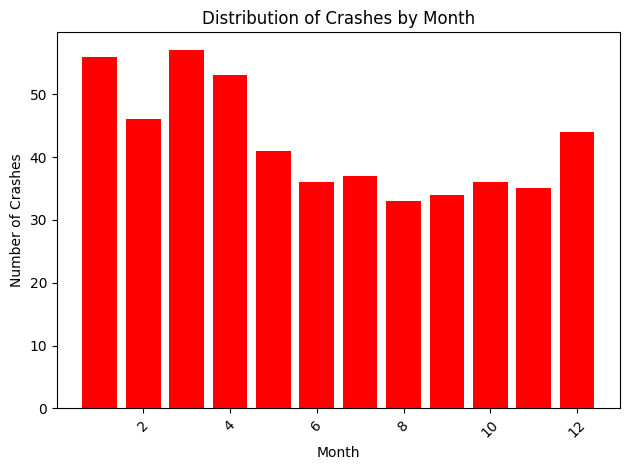

In [53]:
# Statistics assertion
import matplotlib.pyplot as plt

crash_counts = crash_data['Crash Month'].value_counts()
months = crash_counts.index
counts = crash_counts.values

plt.bar(months, counts, color='Red')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.title('Distribution of Crashes by Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
# Statistics assertion

def alcohol_related_crashes_2019(crash_data):
    # Count alcohol-related crashes in 2019
    filtered_data = crash_data[crash_data['Record Type'] == 1]
    alcohol_related = filtered_data[filtered_data['Alcohol-Involved Flag'] == '1'].shape[1]
    total_crashes=len(filtered_data)



    # Calculate the proportion of alcohol-related crashes in 2019
    actual_proportion = (alcohol_related / total_crashes)*100

    print(f"Total % of Accident Related Crashes is {actual_proportion}")



# Call the function with crash_data and expected_proportion
alcohol_related_crashes_2019(crash_data)

Total % of Accident Related Crashes is 30.905511811023622


There is no data for Alcohol Reported in current Dataset in Participant Data.